In [1]:
import numpy as np
import pandas as pd
import torch
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

%config InlineBackend.figure_format = 'retina'

In [2]:
df = yf.download("ETH-USD", period='max', interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [3]:
df["5d_sma"] = df["Close"].rolling(5).mean()
df["9d_sma"] = df["Close"].rolling(9).mean()
df["17d_sma"] = df["Close"].rolling(17).mean()

In [4]:
sma_list = ["5d_sma", "9d_sma", "17d_sma"]
for i in sma_list:
    df[i] = df[i].fillna(df["Close"])

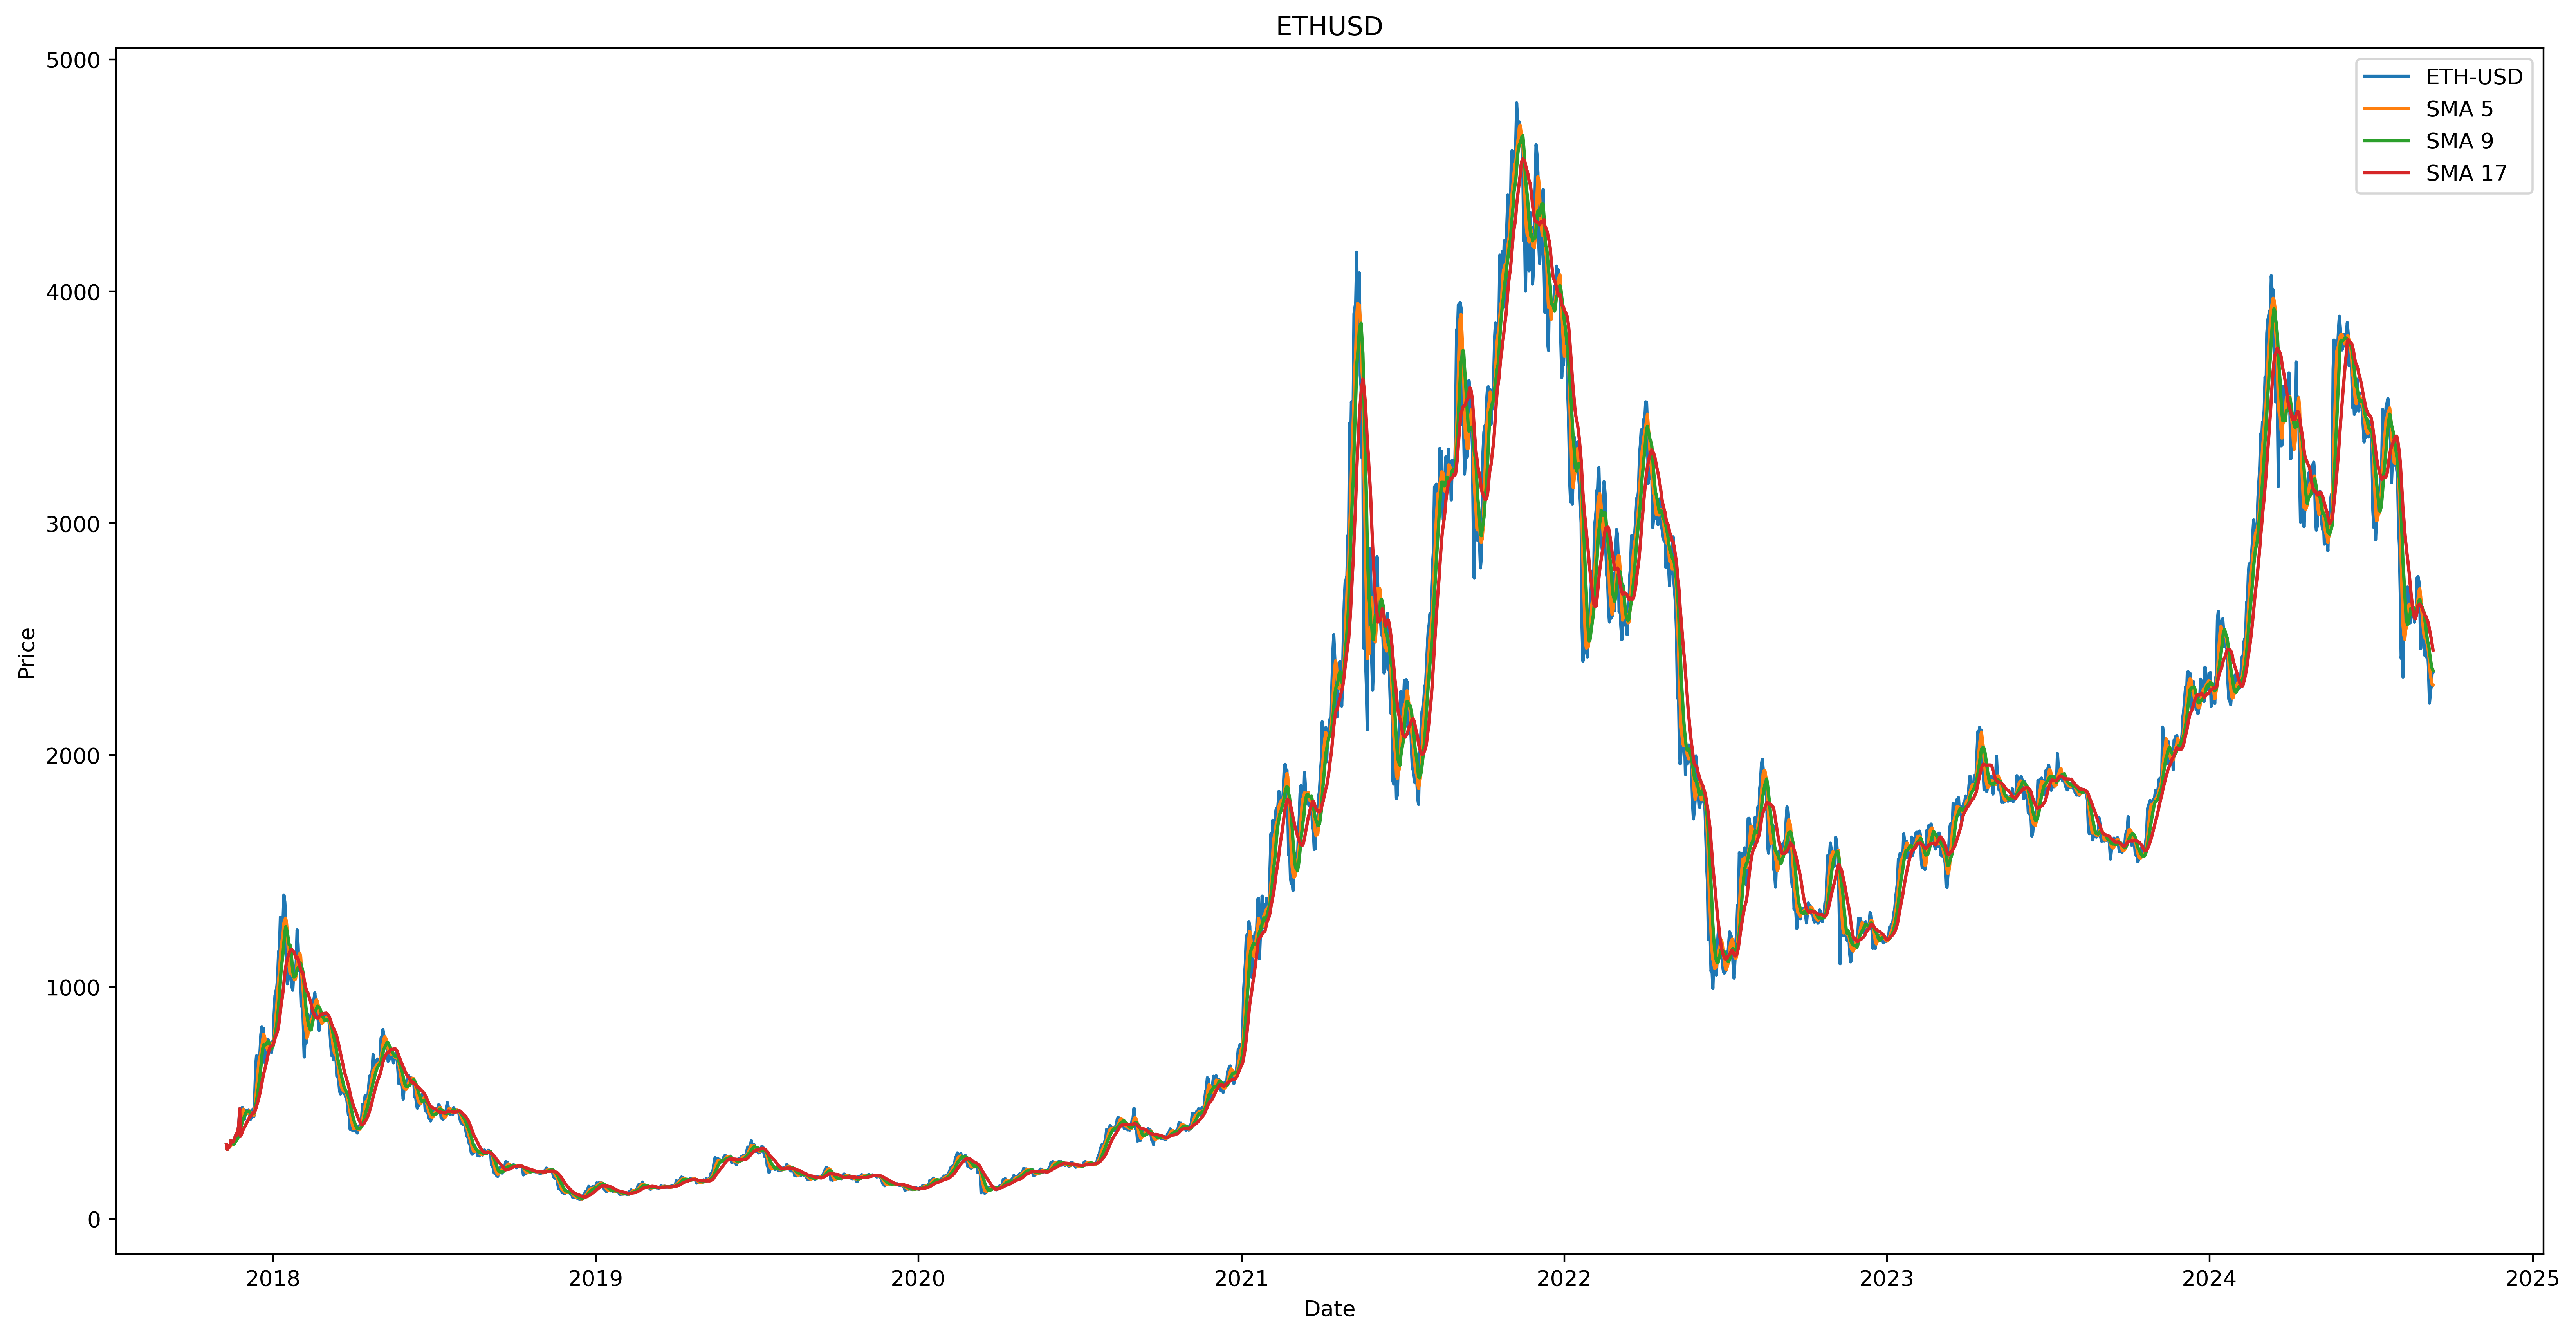

In [5]:
plt.figure(figsize=(20,10), dpi=200)
plt.plot(df.index, df['Close'], label='ETH-USD')
plt.plot(df.index, df['5d_sma'], label='SMA 5')
plt.plot(df.index, df['9d_sma'], label='SMA 9')
plt.plot(df.index, df['17d_sma'], label='SMA 17')
plt.title('ETHUSD')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc='upper right')
plt.show()

In [6]:
def cal_boilinger(df, col, window_size=20, num_std=4, copy=False):
    if copy:
        df = df.copy()
    # Calculate rolling mean and standard deviation 5d
    rolling_mean = np.convolve(df[col], np.ones(window_size)/window_size, mode='valid')
    rolling_std = np.std([df[col][i:i+window_size] for i in range(len(df[col])-window_size+1)], axis=1)
    
    # Calculate Bollinger Bands 5d
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    
    df[f'{col}_upper_band'] = np.concatenate([np.array([np.nan] * (window_size-1)), upper_band])
    df[f'{col}_lower_band'] = np.concatenate([np.array([np.nan] * (window_size-1)), lower_band])
    return df if copy else None

In [7]:
[cal_boilinger(df, i, copy=False) for i in sma_list]

[None, None, None]

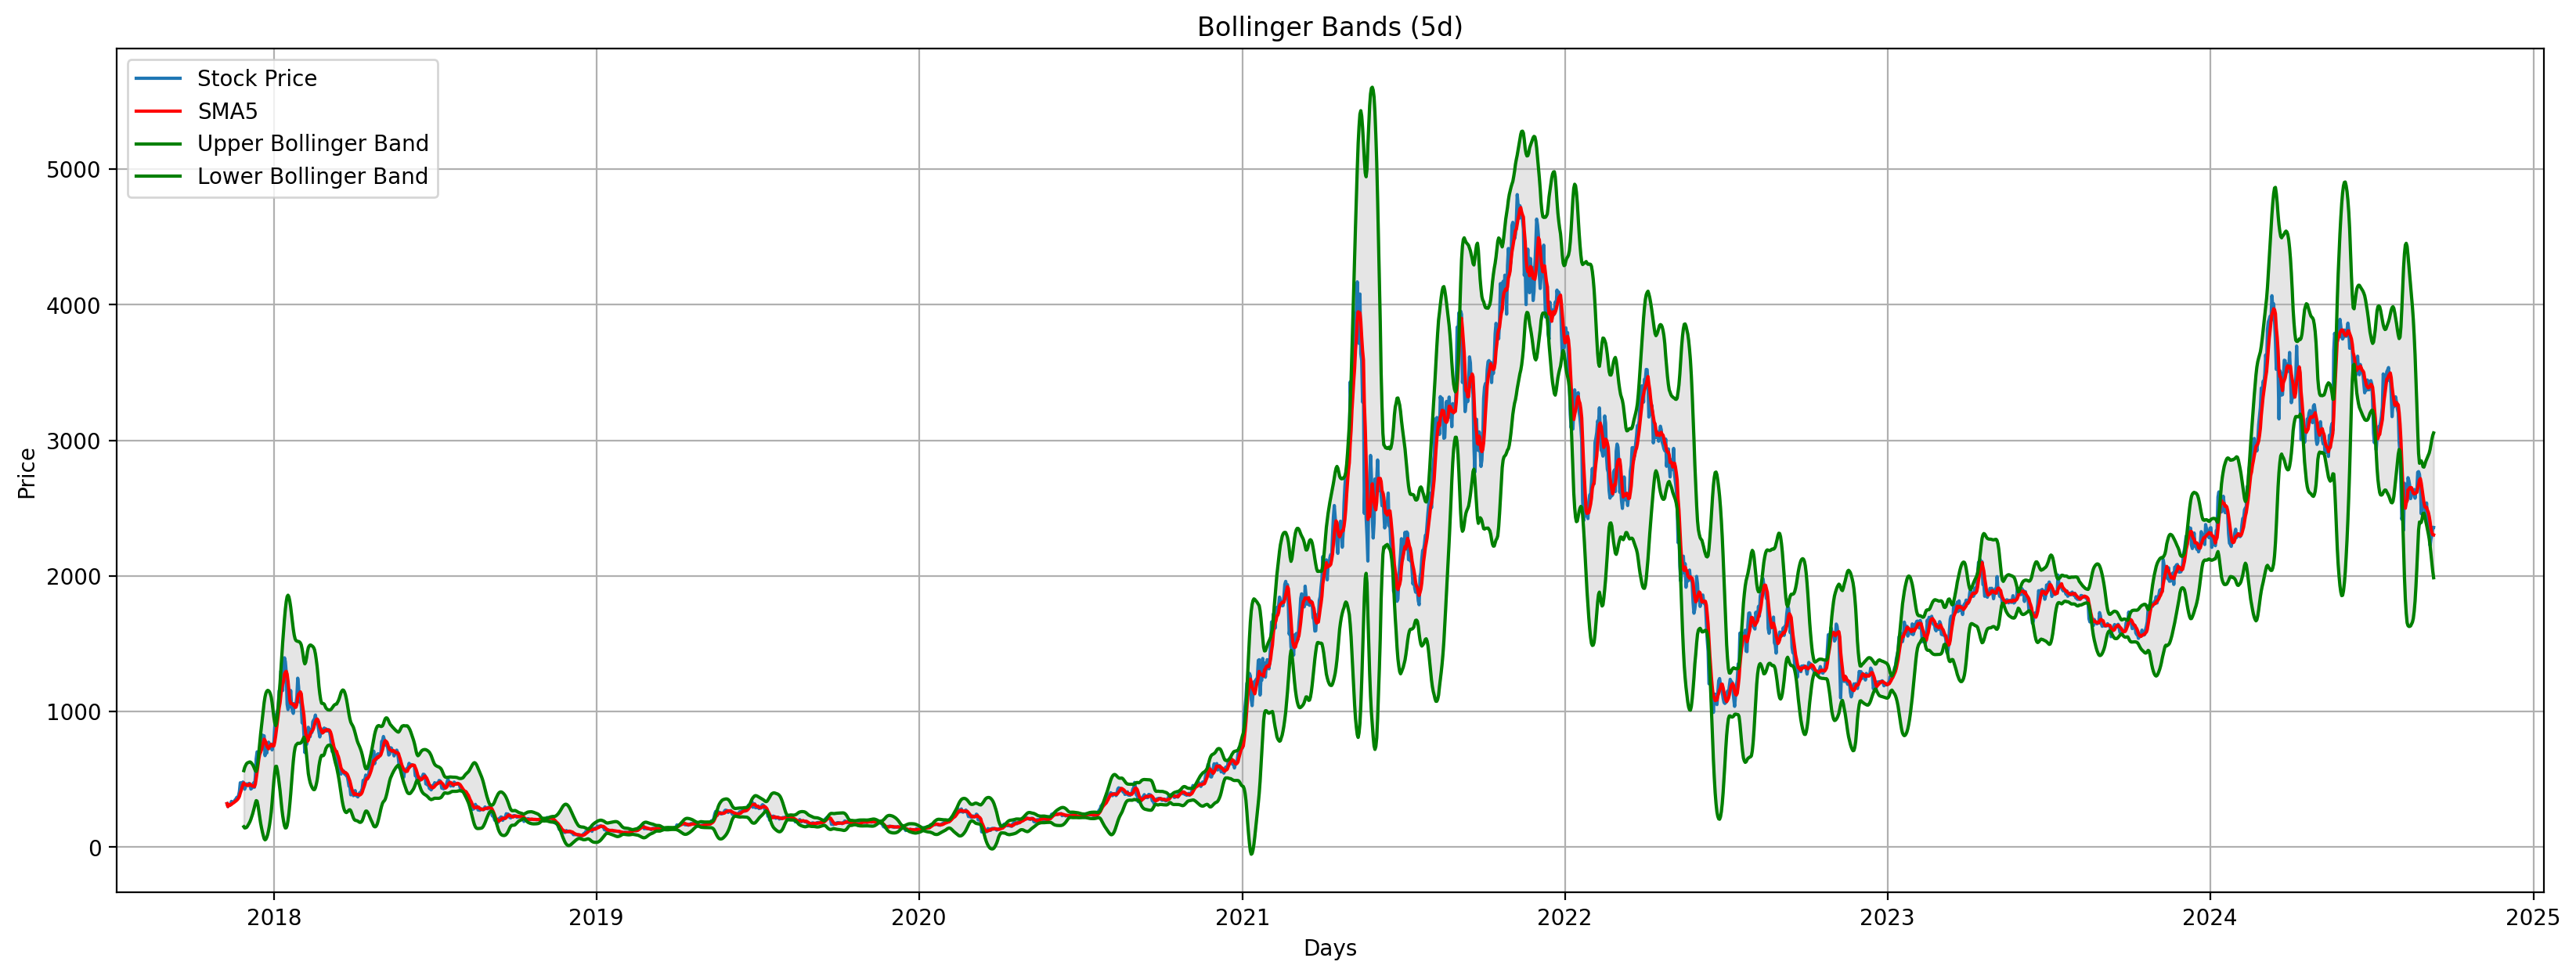

In [8]:
# Define parameters
window_size = 15
num_std = 4

# Plotting 5d
plt.figure(figsize=(20,7))
plt.plot(df['Close'], label='Stock Price')
plt.plot(df['5d_sma'], label='SMA5', color='red')
plt.plot(df['5d_sma_upper_band'], label='Upper Bollinger Band', color='green')
plt.plot(df['5d_sma_lower_band'], label='Lower Bollinger Band', color='green')
plt.fill_between(df.index, df['5d_sma_upper_band'], df['5d_sma_lower_band'], color='grey', alpha=0.2)
plt.title('Bollinger Bands (5d)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

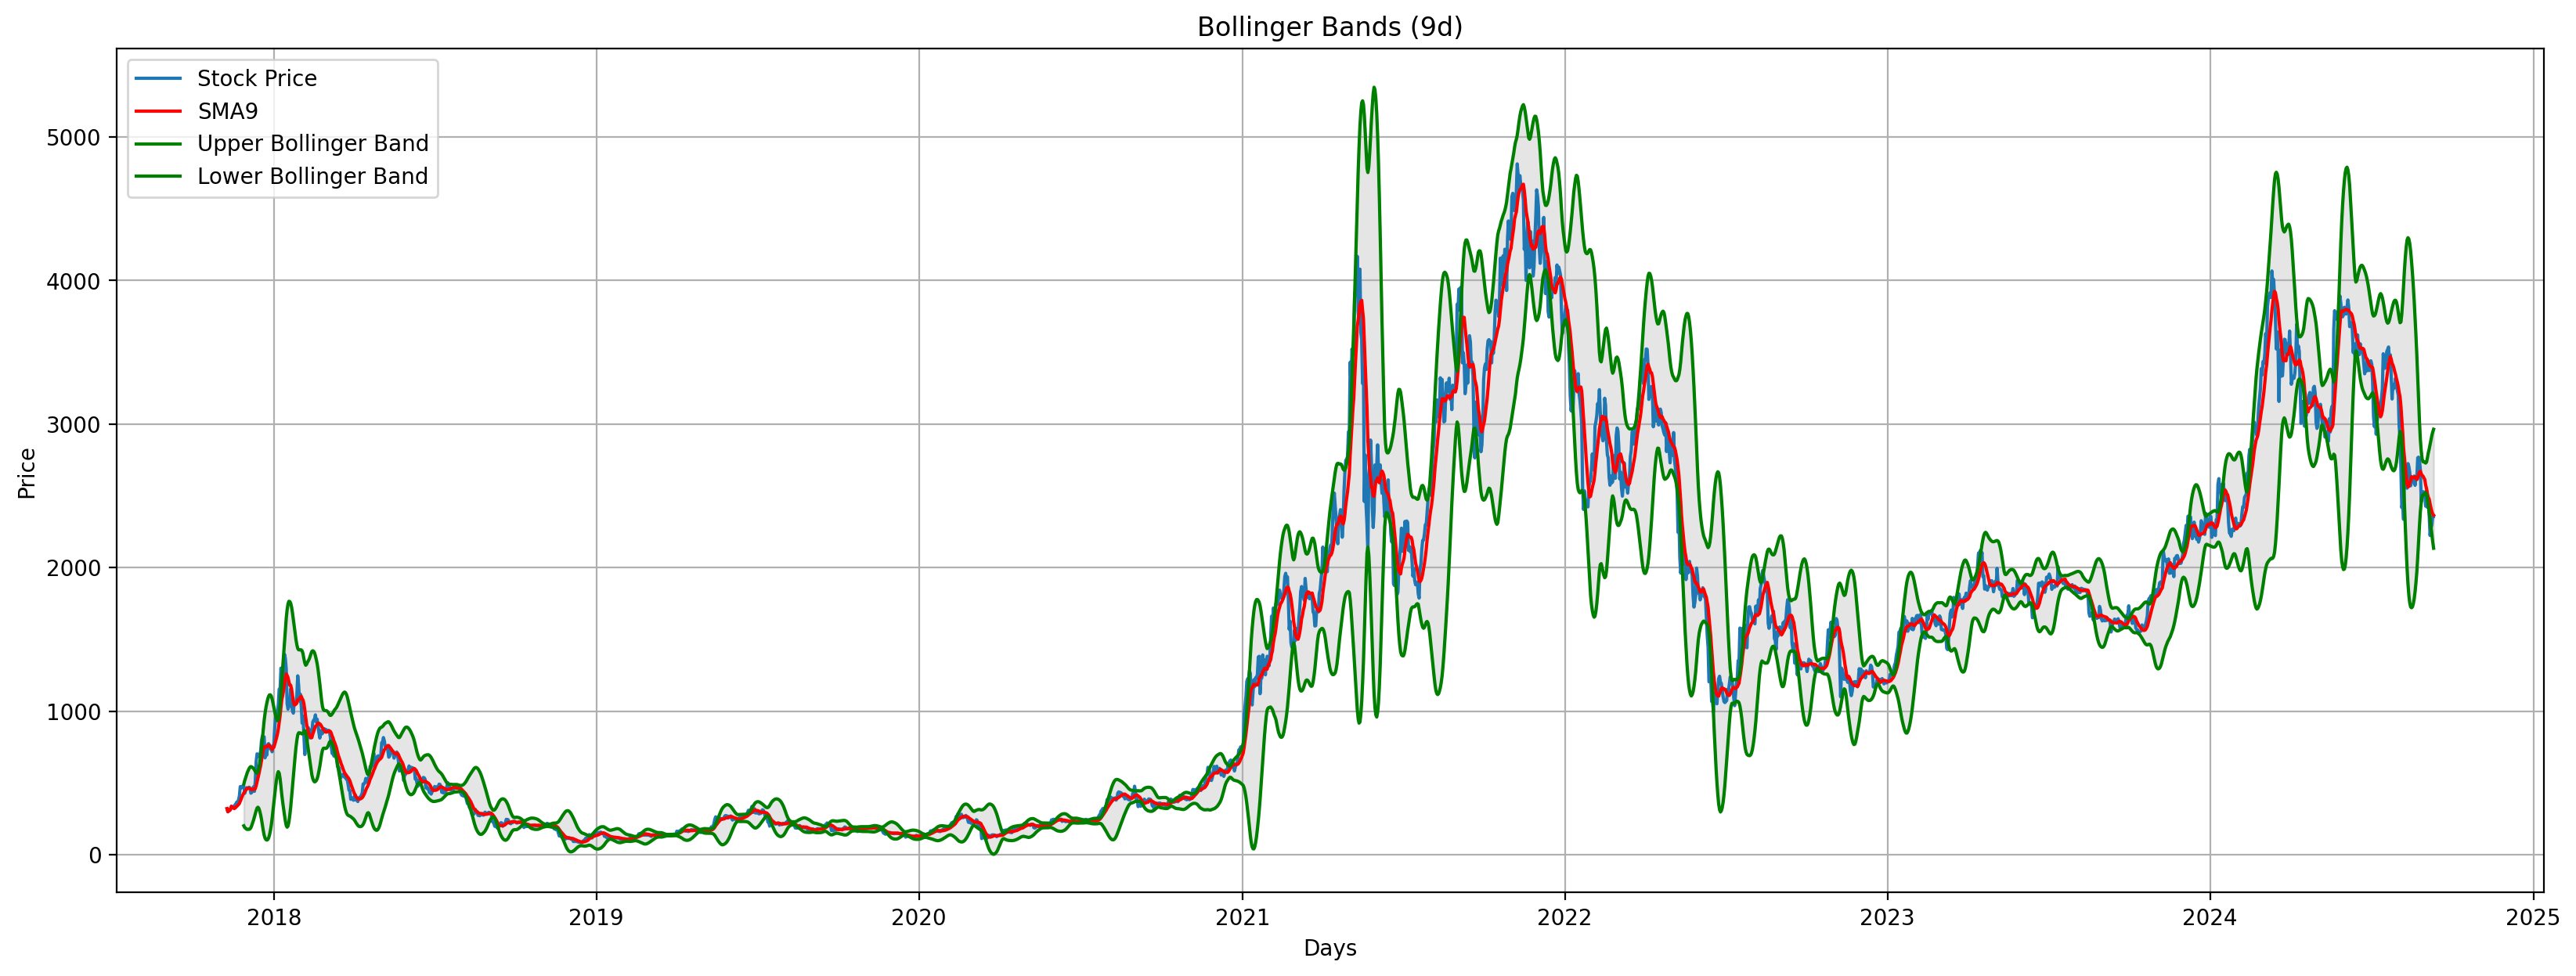

In [9]:
# Plotting 9d
plt.figure(figsize=(20,7))
plt.plot(df['Close'], label='Stock Price')
plt.plot(df['9d_sma'], label='SMA9', color='red')
plt.plot(df['9d_sma_upper_band'], label='Upper Bollinger Band', color='green')
plt.plot(df['9d_sma_lower_band'], label='Lower Bollinger Band', color='green')
plt.fill_between(df.index, df['9d_sma_upper_band'], df['9d_sma_lower_band'], color='grey', alpha=0.2)
plt.title('Bollinger Bands (9d)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

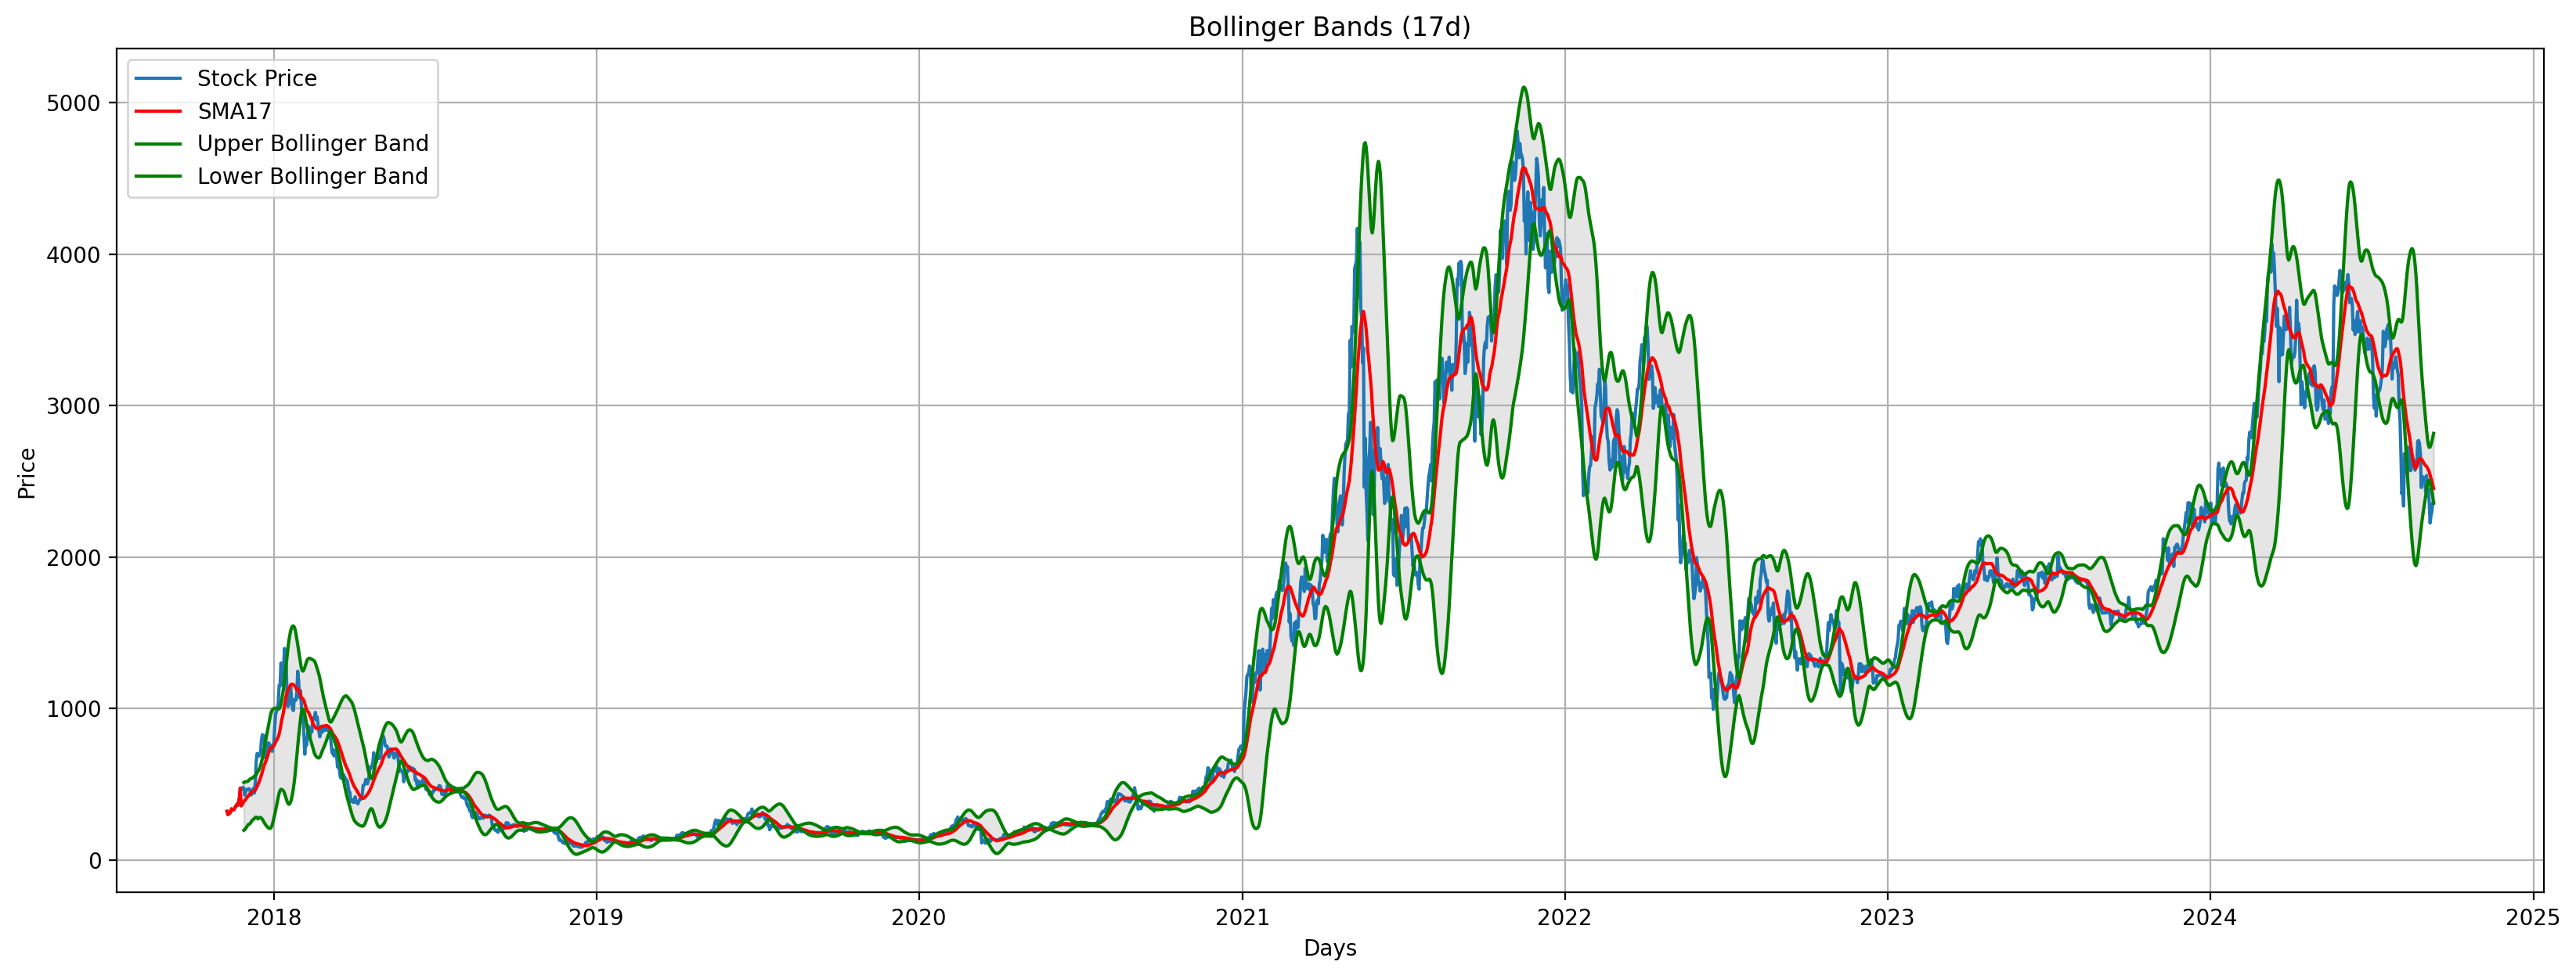

In [10]:
# Plotting 17d
plt.figure(figsize=(20,7))
plt.plot(df['Close'], label='Stock Price')
plt.plot(df['17d_sma'], label='SMA17', color='red')
plt.plot(df['17d_sma_upper_band'], label='Upper Bollinger Band', color='green')
plt.plot(df['17d_sma_lower_band'], label='Lower Bollinger Band', color='green')
plt.fill_between(df.index, df['17d_sma_upper_band'], df['17d_sma_lower_band'], color='grey', alpha=0.2)
plt.title('Bollinger Bands (17d)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

close_price = df[['Close','Open','High','Low']].copy()
# close_price = df[['Close']].copy()
cols = close_price.columns
scaler = MinMaxScaler(feature_range=(1,50))
# scaler = StandardScaler()
close_price = scaler.fit_transform(close_price)

In [17]:
def create_lstm_data(data, time_step=20):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [18]:
x, y = create_lstm_data(close_price, time_step=50)

In [246]:
# calculate the percentage of data for training, validation, and test
val_perc = 0.05
test_perc = 0.05

valid_set_size = int(np.round(val_perc*df.shape[0]))  
test_set_size  = int(np.round(test_perc*df.shape[0]))
train_set_size = df.shape[0] - (valid_set_size + test_set_size)

In [247]:
x_train, x_valid, x_test = torch.tensor(x[:train_set_size], dtype=torch.float32), torch.tensor(x[train_set_size:train_set_size+valid_set_size], dtype=torch.float32), torch.tensor(x[-test_set_size:], dtype=torch.float32)
y_train, y_valid, y_test = torch.tensor(y[:train_set_size], dtype=torch.float32), torch.tensor(y[train_set_size:train_set_size+valid_set_size], dtype=torch.float32), torch.tensor(y[-test_set_size:], dtype=torch.float32)

In [248]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [249]:
from torch import nn
import lightning as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

class LSTM_NN(pl.LightningModule):
    def __init__(self, input_size, hidden_layer_size=64, num_layers=2, lr=1e-3):
        super(LSTM_NN, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.learning_rate = lr

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.linear_out = nn.Linear(hidden_layer_size, input_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.linear(hidden[-1])
        x = self.relu(x)
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear_out(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def fit(self, train_loader, valid_loader, max_epochs=1000):
        early_stop_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
        checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1)
        trainer = pl.Trainer(max_epochs=max_epochs, callbacks=[early_stop_callback, checkpoint_callback])
        trainer.fit(self, train_dataloaders=train_loader, val_dataloaders=valid_loader)
        
    def predict_future(self, recent_sequence, scaler, num_days=2):
        """Generate future predictions based on the recent sequence data

        Args:
            recent_sequence (torch.Tensor): Recent sequence data in tensor format
            scaler (sklearn.preprocessing.Scaler): An instance of the scaler used to scale the data with inverse_transform method
            num_days (int, optional): The number of days to predict into the future. Defaults to 2.

        Returns:
            Array: An array of future predictions
        """
        self.eval()
        recent_sequence_tensor = recent_sequence
        recent_sequence = recent_sequence.detach().numpy()
        future_predictions = []
        for _ in range(num_days):
            with torch.no_grad():
                predicted_scaled_price = self(recent_sequence_tensor)
            # predicted_price = scaler.inverse_transform(predicted_scaled_price.detach().numpy().reshape(1,-1))
            predicted_price = predicted_scaled_price.detach().numpy().reshape(1,-1)
            future_predictions.append(predicted_price)
            
            # Update the recent sequence by removing the first value and adding the new prediction
            new_sequence = np.append(recent_sequence[1:, :], [predicted_scaled_price], axis=0)
            recent_sequence_tensor = torch.tensor(new_sequence, dtype=torch.float32)

        return np.array(future_predictions).squeeze()

In [250]:
torch.manual_seed(42)
model = LSTM_NN(input_size=x_train.shape[-1], hidden_layer_size=64, num_layers=1).to('mps')
model.fit(train_loader, valid_loader, max_epochs=300)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type   | Params | Mode 
----------------------------------------------
0 | lstm       | LSTM   | 17.2 K | train
1 | linear     | Linear | 4.2 K  | train
2 | linear_out | Linear | 65     | train
3 | relu       | ReLU   | 0      | train
----------------------------------------------
21.4 K    Trainable params
0         Non-trainable params
21.4 K    Total params
0.086     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/pax/miniconda3/envs/price/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

/Users/pax/miniconda3/envs/price/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 152.673


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 36.924 >= min_delta = 0.0. New best score: 115.750


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 92.901 >= min_delta = 0.0. New best score: 22.849


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 12.767 >= min_delta = 0.0. New best score: 10.081


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.241 >= min_delta = 0.0. New best score: 9.840


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 7.464 >= min_delta = 0.0. New best score: 2.376


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.589 >= min_delta = 0.0. New best score: 1.787


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.186 >= min_delta = 0.0. New best score: 1.600


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.281 >= min_delta = 0.0. New best score: 1.319


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.298


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.272


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.272. Signaling Trainer to stop.


In [260]:
torch.save(model, 'model.pt')

In [252]:
with torch.no_grad():
    pred = model(x_test)
pred = pred.detach().numpy()
pred = scaler.inverse_transform(pred)

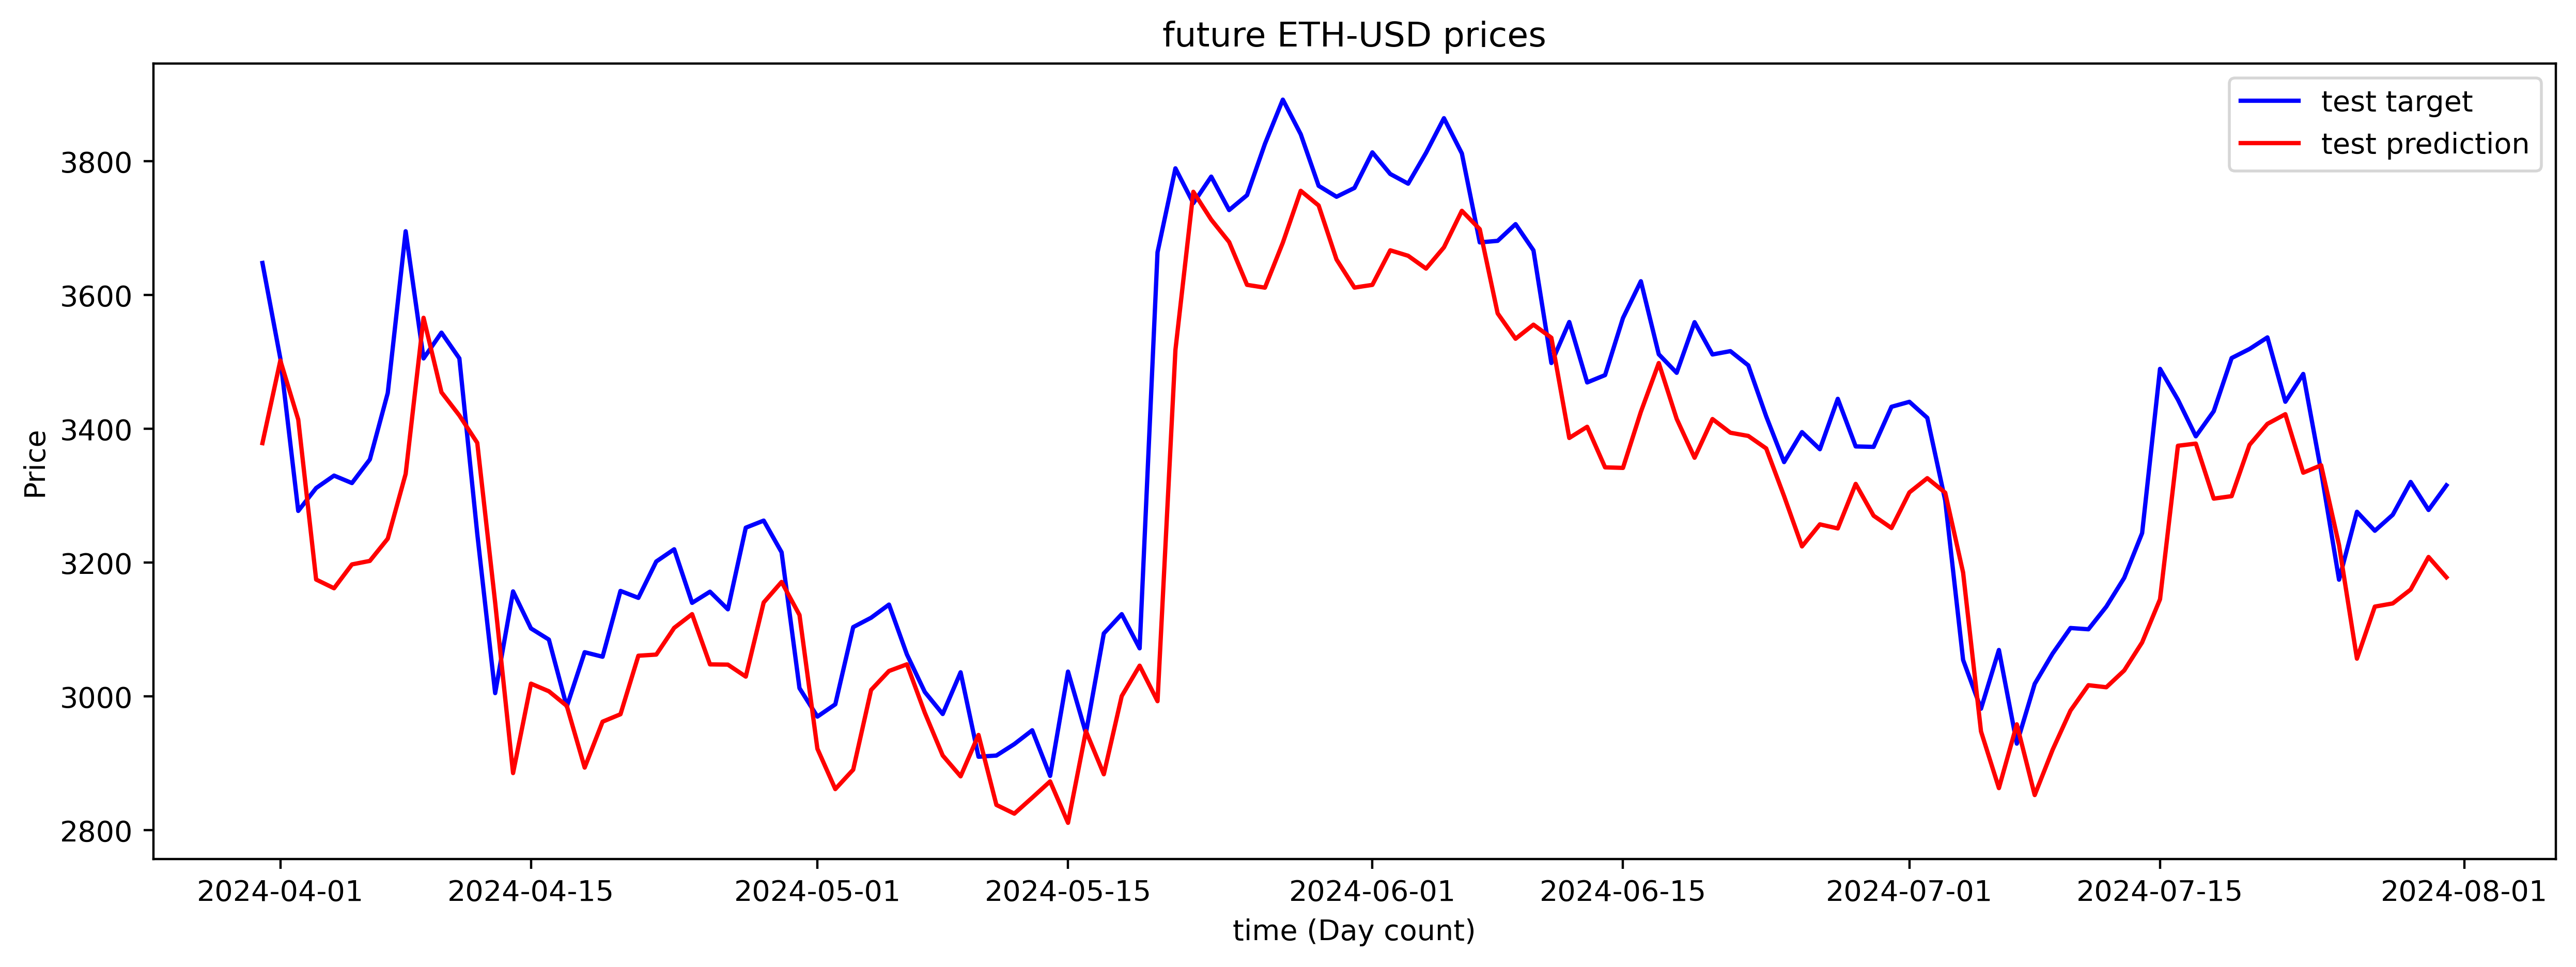

In [253]:
plt.figure(figsize=(15,5), dpi=200)
plt.plot(df[train_set_size+valid_set_size:].index, df[train_set_size+valid_set_size:].Close, color='blue', label='test target')

plt.plot(df[train_set_size+valid_set_size:].index, pred[:,0], color='red', label='test prediction')

plt.title('future ETH-USD prices')
plt.xlabel('time (Day count)')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

In [254]:
with torch.no_grad():
    pred = model(torch.tensor(x, dtype=torch.float32))
pred = pred.detach().numpy()
pred = scaler.inverse_transform(pred)
df['Close_pred'] = np.nan
df['Close_pred'].iloc[-len(pred):] = pred[:,0].squeeze()

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_85331/3083991998.py:6: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_85331/3083991998.py:6: SettingWithCopyWarning:


A val

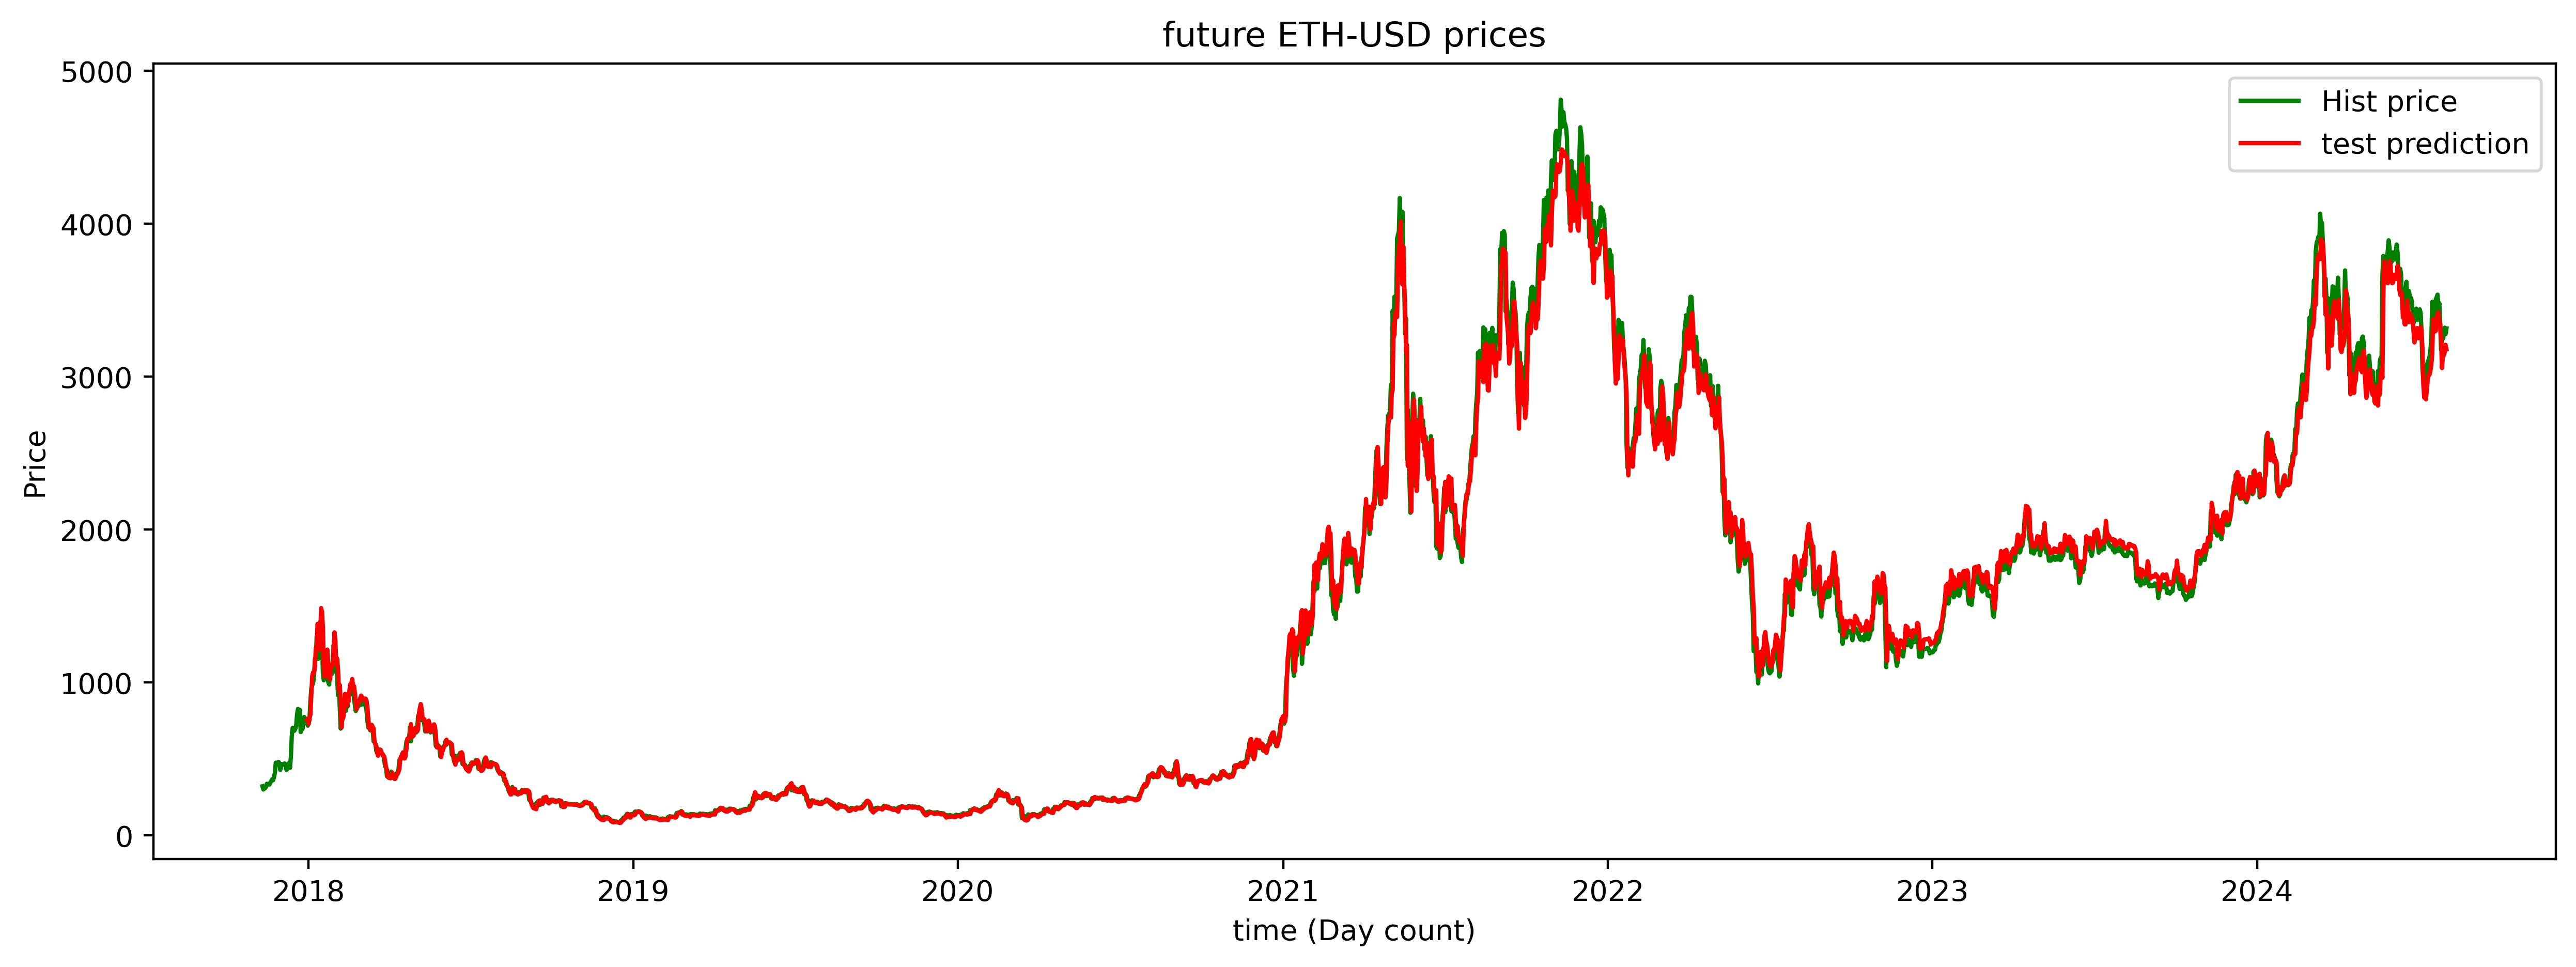

In [255]:
plt.figure(figsize=(15,5), dpi=200)

plt.plot(df.index + pd.DateOffset(days=1), df.Close, color='green', label='Hist price')
plt.plot(df.index + pd.DateOffset(days=1), df.Close_pred, color='red', label='test prediction')

plt.title('future ETH-USD prices')
plt.xlabel('time (Day count)')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

In [256]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(
                x = df.index, # date values
                open = df['Open'],
                high = df['High'],
                low = df['Low'],
                close = df['Close'],
                increasing_line_color = 'green',
                decreasing_line_color = 'red')])

# Mask a default range slider
fig.update_layout(xaxis_rangeslider_visible=False)

# Set layout size
fig.update_layout(
    autosize=False,
    width=1200,
    height=500)

In [261]:
pred = model(torch.cat([x_train, x_valid, x_test], dim=0))
pred = pred.detach().numpy()
pred = scaler.inverse_transform(pred)
df_ = pd.DataFrame(pred, columns=cols, index=df.index)

In [262]:
future_predictions = model.predict_future(x_test[-1,:,:], scaler, num_days=5)
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1,1))

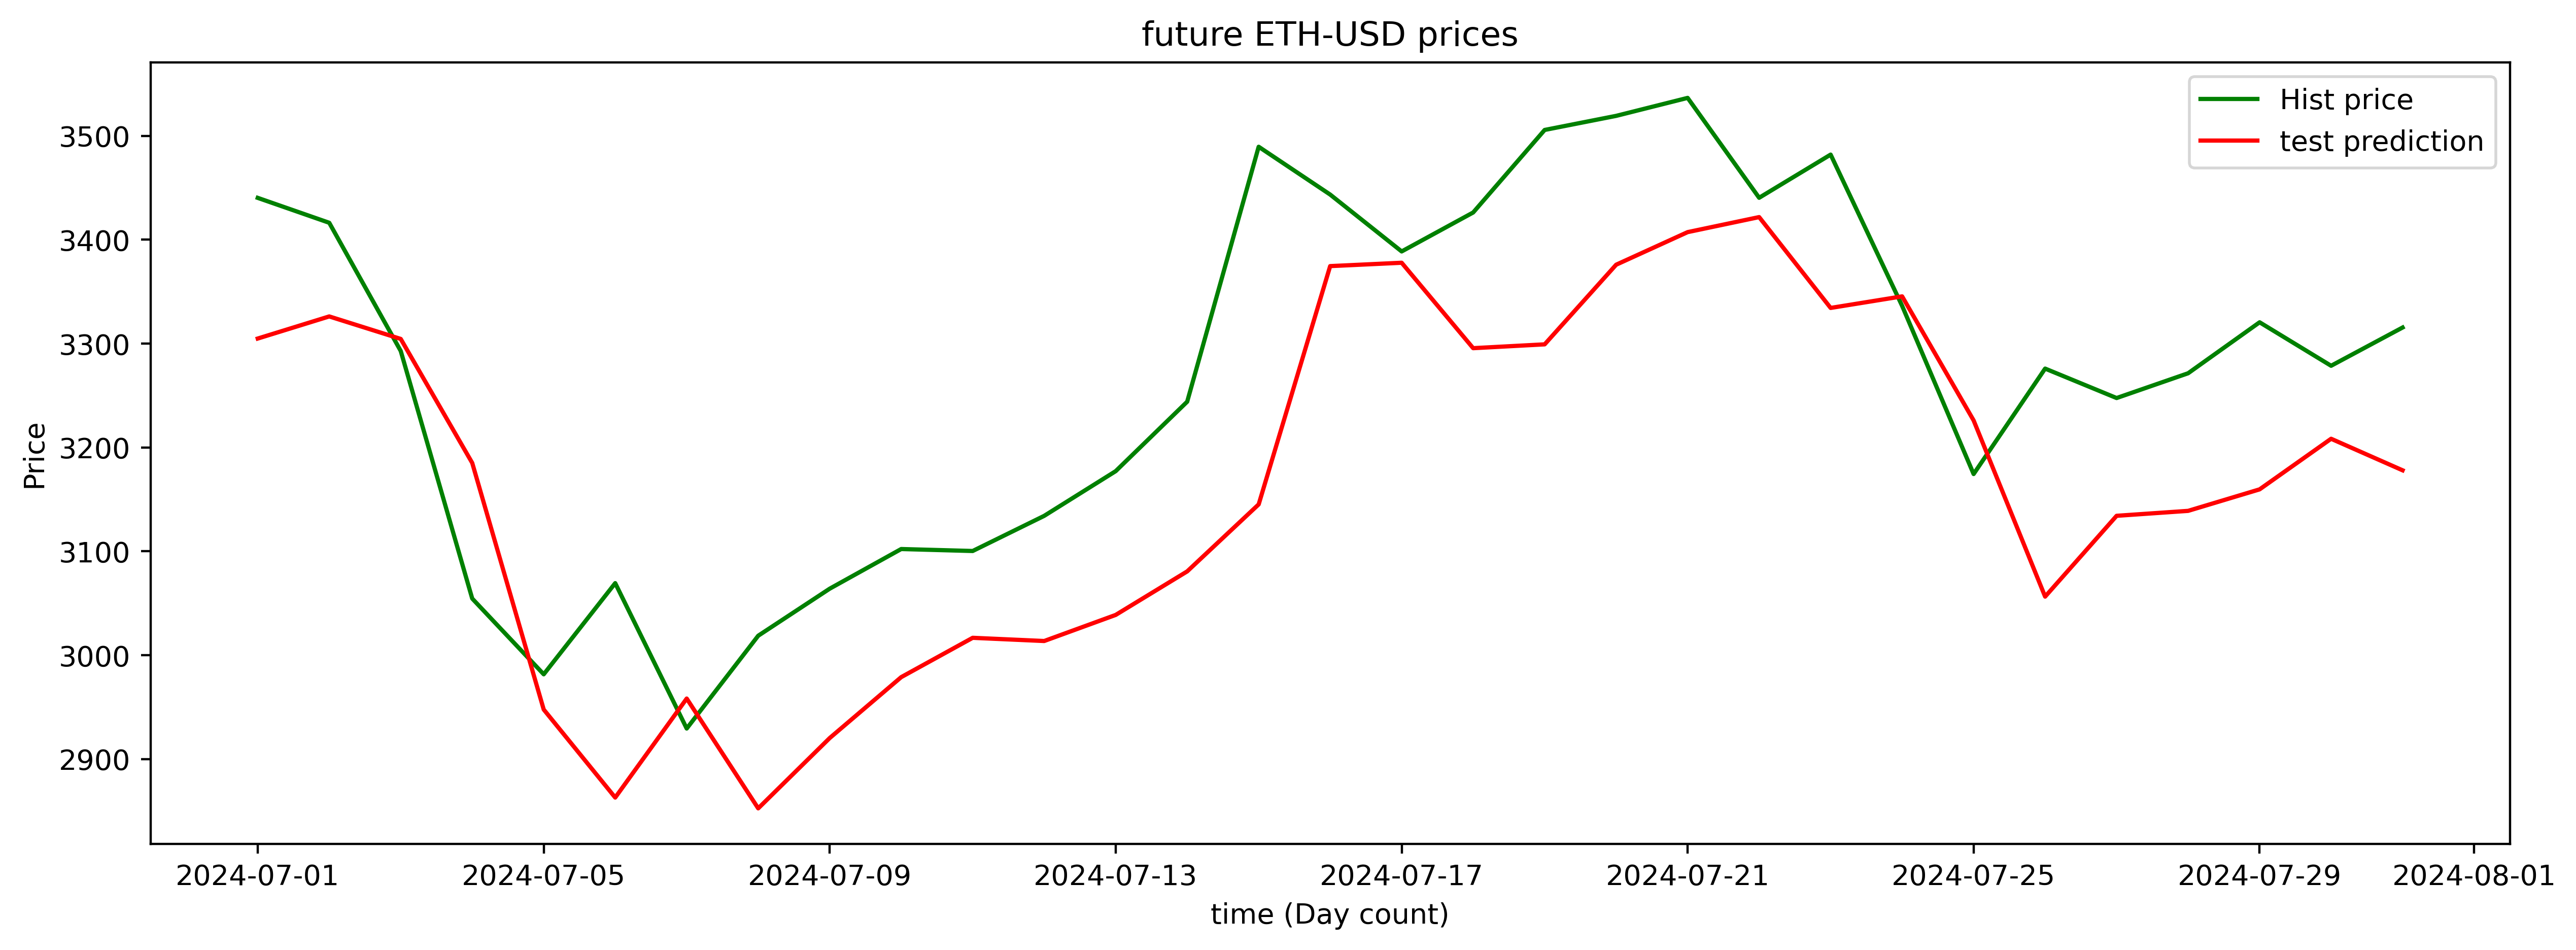

In [263]:
plt.figure(figsize=(15,5), dpi=200)

plt.plot(df.loc['2024-07-01':].index, df.loc['2024-07-01':].Close, color='green', label='Hist price')
plt.plot(df.loc['2024-07-01':].index, df.loc['2024-07-01':].Close_pred, color='red', label='test prediction')

plt.title('future ETH-USD prices')
plt.xlabel('time (Day count)')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

In [264]:
# Assuming you have the last date of your training data
last_date = pd.Timestamp(datetime.datetime.today().date())

# Generate future dates
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, len(future_predictions) + 1)]

# Create a DataFrame with future predictions
future_df = pd.DataFrame(future_predictions, columns=['Close_pred'], index=future_dates)

future_df.index.name = 'Date'
future_df

Close_pred
Date                   
2024-08-01  3178.014404
2024-08-02  3075.005615
2024-08-03  2981.759033
2024-08-04  2897.456299
2024-08-05  2821.316406

In [265]:
df_pred = df[['Close', 'Close_pred']].copy()
df_pred = pd.concat([df_pred, future_df], axis=0)

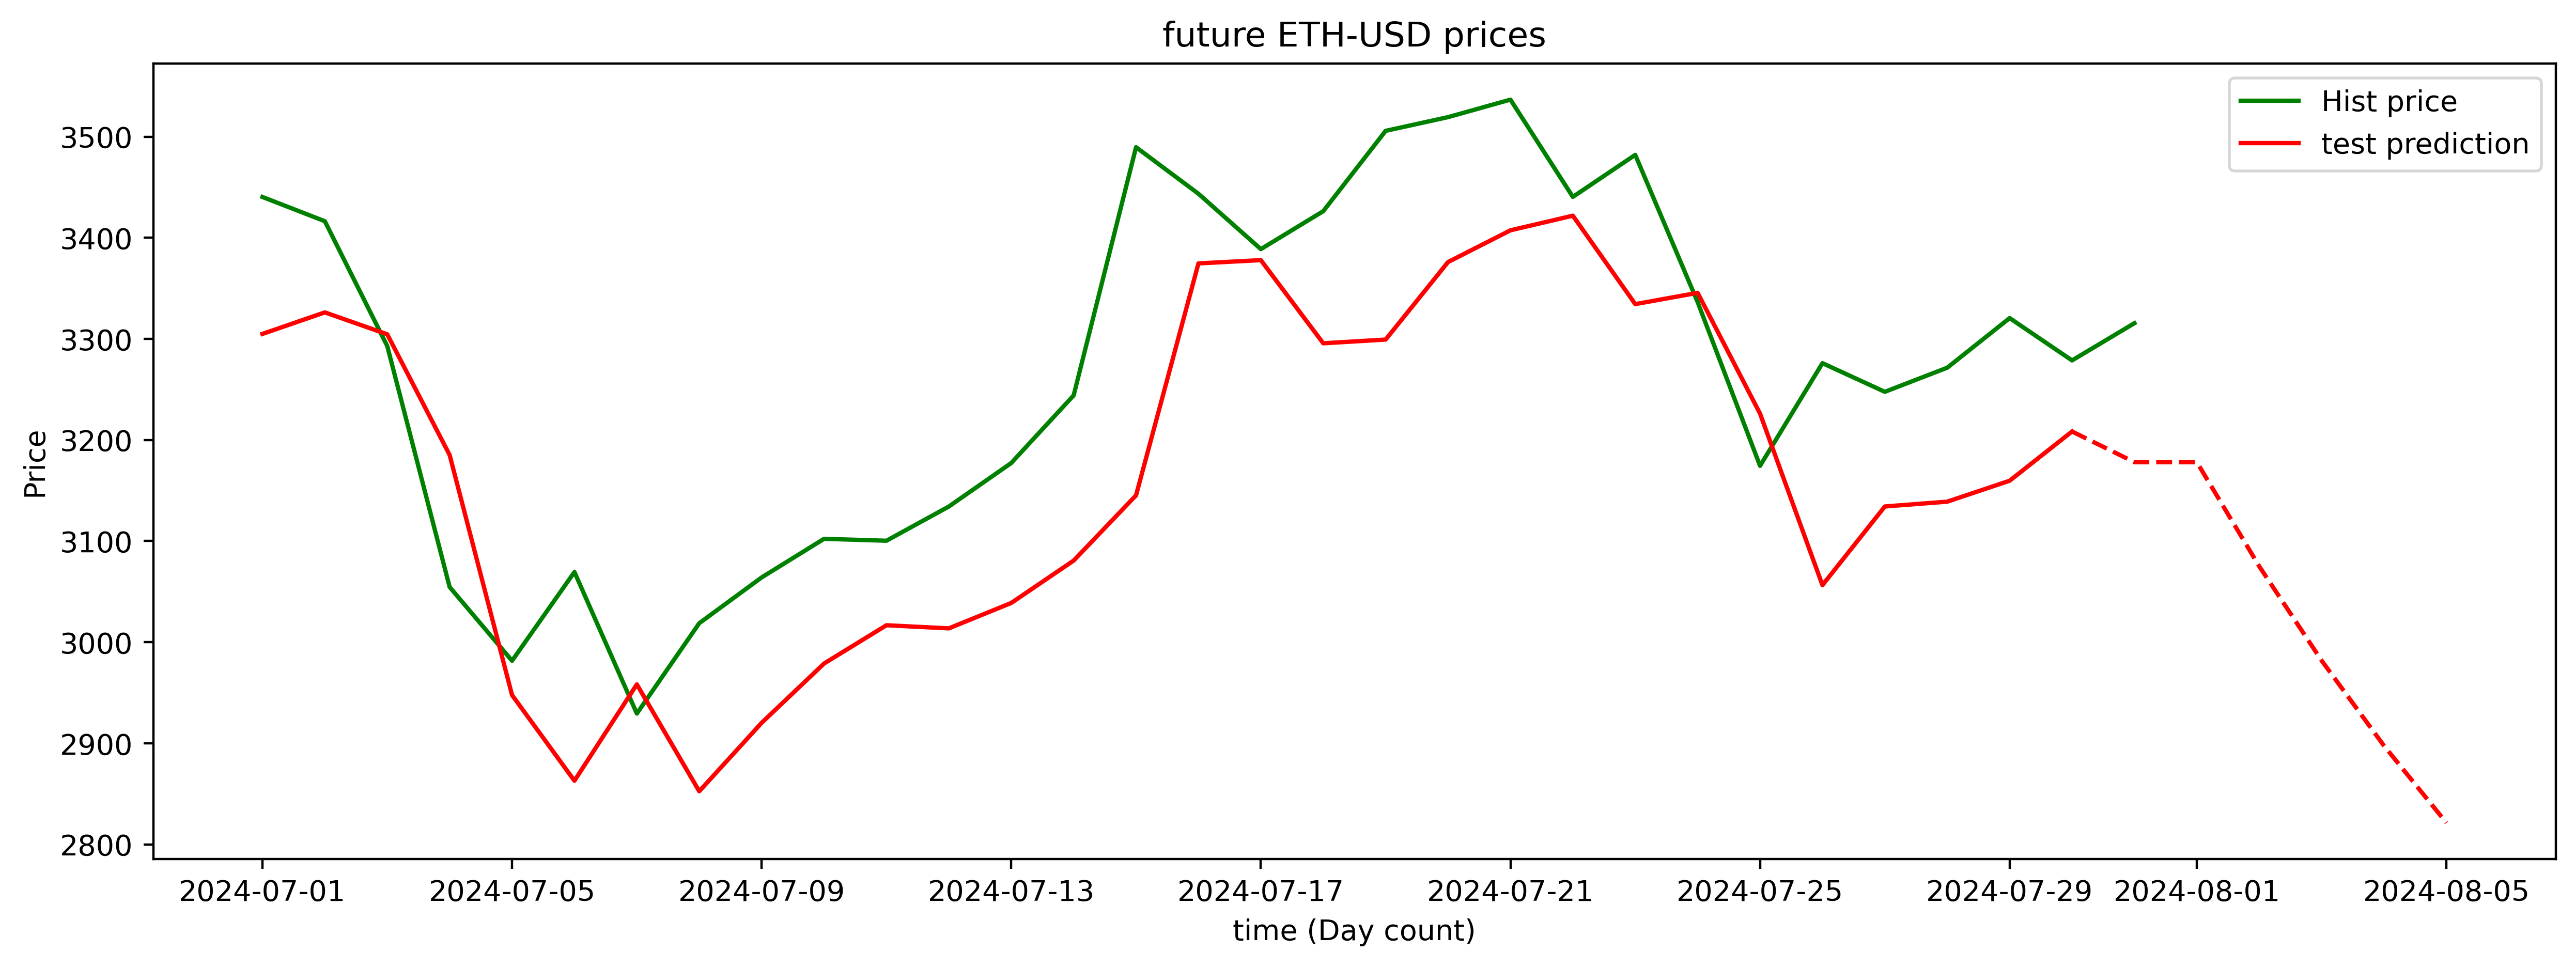

In [269]:
plt.figure(figsize=(15,5), dpi=200)

plt.plot(df_pred.loc['2024-07-01':].index, df_pred.loc['2024-07-01':].Close, color='green', label='Hist price')
plt.plot(df_pred.loc['2024-07-01':'2024-07-30'].index, df_pred.loc['2024-07-01':'2024-07-30'].Close_pred, color='red', label='test prediction')
plt.plot(df_pred.loc['2024-07-30':].index, df_pred.loc['2024-07-30':].Close_pred, color='red', linestyle='--')

plt.title('future ETH-USD prices')
plt.xlabel('time (Day count)')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()